In [32]:
import requests
import spacy
import json

In [33]:
nlp = spacy.load("en_core_web_sm")

API_KEY = open('apikey').read()

baltimore_harbor = {
    "circle": {
        "center": {
            "latitude": 39.2820552,
            "longitude": -76.6051076
        },
        "radius": 500
    }
}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.4.0) was trained with spaCy v3.4.0 and may not be 100% compatible with the current version (3.7.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [34]:
def nearby_places(locationRestriction, url="https://places.googleapis.com/v1/places:searchNearby"):
    body = {
        "maxResultCount": 10,
        "locationRestriction": locationRestriction
    }

    headers = {
        "X-Goog-Api-Key": API_KEY,
        "X-Goog-FieldMask": "places.displayName,places.photos"
    }
    
    r = requests.post(url, headers=headers, json=body)
    return r.json()

In [35]:
places = nearby_places(baltimore_harbor)
# places = json.load(open("places"))
places

{'places': [{'displayName': {'text': 'National Aquarium',
    'languageCode': 'en'},
   'photos': [{'name': 'places/ChIJXVZn5GIDyIkRjn58fGGo8Mc/photos/AcJnMuFDwNt6-CRHuC4MC3bbhL76OyZ1nhZKLoPuQ20U4GEBWRDGCS68QKwuMU-NIDz2G5sgEZP4JaO41XiaA6WPLYItQhwcShqCnkSr3DXcElsPXlV4qamz72Q0AViCwyAh-PZFUg1Cp1zM_UgIB1njgdID_Z2qHmXlMRbV',
     'widthPx': 4032,
     'heightPx': 3024,
     'authorAttributions': [{'displayName': 'Cody Anderson',
       'uri': '//maps.google.com/maps/contrib/102004674886082438883',
       'photoUri': '//lh3.googleusercontent.com/a/ACg8ocIwwnkYyw-BFqGIdnwExhhT-by6Ptddb2dtFxR68QDS=s100-p-k-no-mo'}]},
    {'name': 'places/ChIJXVZn5GIDyIkRjn58fGGo8Mc/photos/AcJnMuHNFUhZKSFWuUH4HMbX1Io_r38hzcxlLhUxYI5NYq4GJrYH51Fo81iJPQaZzL63rBPVoFaIL0kktCf381Pub_JqTf10rWOn-TmcutPr-MkGnJ89DE8TaqxRm4c21TRY1cEjKwSRkognBSaqqDgSBAuRvE0Ygw6qK-4C',
     'widthPx': 4032,
     'heightPx': 3024,
     'authorAttributions': [{'displayName': 'Chloe Trippe',
       'uri': '//maps.google.com/maps/contrib/11621

In [6]:
reviews = {p['displayName']['text']: [i['text']['text'] for i in p['reviews']] for p in places['places']}

In [9]:
from collections import Counter

reviews_counter = {}
for n, rs in reviews.items():
    adjs = [token.lemma_ for r in rs for token in nlp(r) if token.pos_ == "ADJ"]
    reviews_counter[n] = Counter(adjs)
reviews_counter

{'National Aquarium': Counter({'other': 3,
          'big': 3,
          'cool': 3,
          'great': 3,
          'hard': 2,
          'super': 2,
          'clean': 2,
          'worth': 2,
          'beautiful': 2,
          'busy': 2,
          'fantastic': 2,
          'more': 2,
          'happy': 2,
          'few': 2,
          'good': 2,
          'vertical': 2,
          'impressive': 1,
          'surprised': 1,
          'modern': 1,
          'easy': 1,
          'many': 1,
          'amazing': 1,
          'entire': 1,
          'little': 1,
          'confusing': 1,
          'wide': 1,
          'tropical': 1,
          'worthy': 1,
          'friendly': 1,
          'underwater': 1,
          'huge': 1,
          'fun': 1,
          'awesome': 1,
          'sure': 1,
          'jellyfish': 1,
          'hidden': 1,
          'favorite': 1,
          'unimpressed': 1,
          'most': 1,
          'small': 1,
          'various': 1,
          'geographical': 1,
      

In [38]:
# place photos: https://developers.google.com/maps/documentation/places/web-service/place-photos
photos = {p['displayName']['text']: [i['name'] for i in p['photos']][0] for p in places['places']}
photos

{'National Aquarium': 'places/ChIJXVZn5GIDyIkRjn58fGGo8Mc/photos/AcJnMuFDwNt6-CRHuC4MC3bbhL76OyZ1nhZKLoPuQ20U4GEBWRDGCS68QKwuMU-NIDz2G5sgEZP4JaO41XiaA6WPLYItQhwcShqCnkSr3DXcElsPXlV4qamz72Q0AViCwyAh-PZFUg1Cp1zM_UgIB1njgdID_Z2qHmXlMRbV',
 'Baltimore Marriott Waterfront': 'places/ChIJF8OQQ3wDyIkRMQDwjaW-anw/photos/AcJnMuGyxnJVfeGqGDiSWKs_tFHaUwvJ4O-zj6P98_qhMcHdkvD7GNKirWk9ZFn87XtD9Moz0B9tr-IDJLLINp9iL5PN6s4_ojEl5ge1aVSAt3tcpkCmCMrrajOD_ZRAY_CcAcRarELBCJRW958v43A5vygmZy7Isndah0oF',
 'Four Seasons Hotel Baltimore': 'places/ChIJPx3RFHwDyIkRmQZ9bSzsfr4/photos/AcJnMuH39Mhe9MDO6fpo07wOa0Ox2sJbuDlGD-BTnwGhe2z3jgx3WBv83CawCRTtem8ns1FSlBqWstmQGGLG4swc4U1RKl3l2fNE0l7c8YQHcGE9U1bh3HX78rY14tqndfEBGpOSi_UaTXAiueuxhvdVQOA1HrHV_QRaUStU',
 'Baltimore Aquarium': 'places/ChIJQeJIwW0FyIkRDGXr04XiYO0/photos/AcJnMuFo_A4OM_EfmHaGEd0sHmcmpZTpuS1Z5v1dInLgN4j8IwfJ-TUpIe2RW04oJG8JWWlA0Exd60B7gpzBg-fS4qpt63HignrT62ydkFeQV8wkNatXiUa69185oFZosZPejWfaBeuisTGdy-g_cv6UbjyzRaxE-rPInjYO',
 'Rusty Scupper Restaurant & Bar

In [72]:
# https://openai.com/pricing
# pricing is determined by number of 512x512 blocks in an image
def get_photo(name, size=512, url="https://places.googleapis.com/v1/{name}/media?key={key}&maxHeightPx={size}&maxWidthPx={size}"):
    r = requests.get(url.format(name=name, key=API_KEY, size=size), stream=True)
    return r.content


In [73]:
import shutil
# p = get_photo('places/ChIJ20bAk1D2t4kRScYfblDwzI0/photos/AcJnMuFBCoGeGigltVI_6r8MMj_TbqkHTGJsunAd6RYeZ1lFpWinlJu13WIMikgvlouoJU610z6vPyZU8CozwDuK-6VkWmYFO9Ip9Bks8ATZ5umLpANv--rdMuaWDltLobPAC4RRGOy4yW7mFNGMPFnealinrjGnN8XtqktI')
# with open('img.jpg', 'wb') as out_file:
#     shutil.copyfileobj(p, out_file)

p = get_photo('places/ChIJpSrZMXwDyIkRqfr9Cz9T_ho/photos/AcJnMuGBeYN17jy2P7CrkY1WMHh2moxo7clLa6gSAx8wXhn9KeA2g6Ep75YcRsGSBmFLg5m2PU19DKj-pAr5LUPKmoYn8r0VpbgTX-I5WcrzNypGGk0Xn1z-_fGsU4v91KJcU_HBKqFGWyoR_1ySaPJAsSX_9tOfFRYb8IgV')


In [76]:
from base64 import b64encode
b = b64encode(open('img.jpg', 'rb').read())
b = b64encode(p)


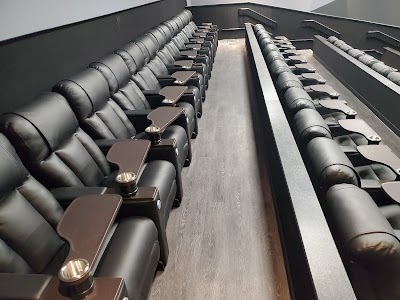

In [77]:
from IPython import display
from base64 import b64decode
from io import BytesIO 
from PIL import Image

display.Image(b64decode(b))

In [66]:
from openai import OpenAI

In [67]:
openapikey = open("openapikey").read()

In [68]:
client = OpenAI(api_key=openapikey)

In [79]:
import base64
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')


base64_image = b.decode('utf-8')

In [80]:
response = client.chat.completions.create(
  model="gpt-4-vision-preview",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "Use exactly ten adjectives and no more words to describe the buildings in image."},
        {
          "type": "image_url",
          "image_url": {
#             "url": "https://upload.wikimedia.org/wikipedia/commons/9/9c/BaltimoreNationalAquarium.JPG",
              "url": f"data:image/jpeg;base64,{base64_image}"
          },
        },
      ],
    }
  ],
  max_tokens=300,
)

print(response.choices[0])

Choice(finish_reason=None, index=0, message=ChatCompletionMessage(content='Modern, comfortable, tiered, cushioned, spacious, luxurious, black, elegant, sleek, contemporary.', role='assistant', function_call=None, tool_calls=None), finish_details={'type': 'stop', 'stop': '<|fim_suffix|>'})


In [27]:
# headers = {
#   "Content-Type": "application/json",
#   "Authorization": f"Bearer {openapikey}"
# }

# payload = {
#   "model": "gpt-4-vision-preview",
#   "messages": [
#     {
#       "role": "user",
#       "content": [
#         {
#           "type": "text",
#           "text": "What’s in this image?"
#         },
#         {
#           "type": "image_url",
#           "image_url": {
#             "url": f"data:image/jpeg;base64,{base64_image}"
#           }
#         }
#       ]
#     }
#   ],
#   "max_tokens": 300
# }

# response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

# print(response.json())

{'error': {'message': 'Something went wrong processing one of your images.', 'type': 'server_error', 'param': None, 'code': None}}
